In [4]:
import torch
import torchvision
import numpy
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

In [8]:
%matplotlib inline

In [5]:
datasets = FashionMNIST(root='data/', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 14929799.97it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265716.98it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4978418.32it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13295737.06it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [13]:
datasets.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
len(datasets)

60000

Label:  0


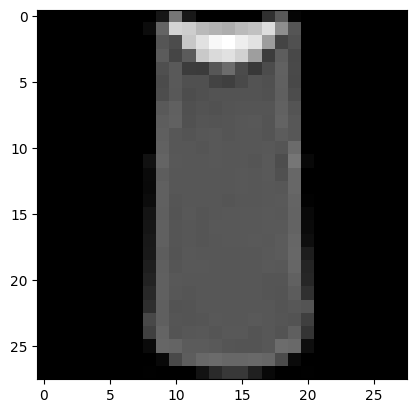

In [10]:
images, labels = datasets[2]
plt.imshow(images[0], cmap='gray')
print('Label: ', labels)

In [14]:
from torchvision.utils import make_grid

In [32]:
validation_data = 10000
training_data = len(datasets) - validation_data

training_dataset, validation_dataset = random_split(datasets, [training_data, validation_data])
len(training_dataset), len(validation_dataset)

(50000, 10000)

In [33]:
training_dataloader = DataLoader(training_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=100, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [49]:
import torch.nn as nn
import torch.nn.functional as F

In [50]:
class FashionMNISTModel(nn.Module):
  def __init__(self):
    super(FashionMNISTModel, self).__init__()
    self.linear1 = nn.Linear(784, 64)
    self.linear2 = nn.Linear(64, 32)
    self.linear3 = nn.Linear(32, 10)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    return x

  def training_step(self, batch):
    images, labels = batch
    output = self(images)
    loss = F.cross_entropy(output, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    output = self(images)
    loss = F.cross_entropy(output, labels)
    acc = accuracy(output, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [51]:
model = FashionMNISTModel()

In [76]:
def evaluate(model, validation_data):
  outputs = [model.validation_step(batch) for batch in validation_dataloader]
  return model.validation_epoch_end(outputs)

In [53]:
def accuracy(output, labels):
  _, preds = torch.max(output, dim=1)
  return torch.tensor(torch.sum(preds == labels) / len(preds))

In [54]:
def fit(epochs, lr, model, training_dataloader, validation_dataloader, optim_fun=torch.optim.SGD):
  optimizer = optim_fun(model.parameters(), lr)
  history = []

  for epoch in range(epochs):

    # Training Phase
    for batch in training_dataloader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, validation_dataloader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [55]:
history0 = fit(5, 0.1, model, training_dataloader, validation_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-1158f8ce7e6b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels) / len(preds))


Epoch [0], val_loss: 0.6073, val_acc: 0.7786
Epoch [1], val_loss: 0.4688, val_acc: 0.8403
Epoch [2], val_loss: 0.4455, val_acc: 0.8419
Epoch [3], val_loss: 0.4022, val_acc: 0.8617
Epoch [4], val_loss: 0.4068, val_acc: 0.8586


In [56]:
history1 = fit(7, 0.5, model, training_dataloader, validation_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-1158f8ce7e6b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels) / len(preds))


Epoch [0], val_loss: 1.2425, val_acc: 0.5625
Epoch [1], val_loss: 0.7389, val_acc: 0.7157
Epoch [2], val_loss: 0.5435, val_acc: 0.7962
Epoch [3], val_loss: 0.5729, val_acc: 0.7954
Epoch [4], val_loss: 0.5740, val_acc: 0.7928
Epoch [5], val_loss: 0.4901, val_acc: 0.8287
Epoch [6], val_loss: 0.5616, val_acc: 0.8020


In [58]:
history2 = fit(7, 0.09, model, training_dataloader, validation_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-1158f8ce7e6b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels) / len(preds))


Epoch [0], val_loss: 0.4117, val_acc: 0.8593
Epoch [1], val_loss: 0.4135, val_acc: 0.8593
Epoch [2], val_loss: 0.4070, val_acc: 0.8602
Epoch [3], val_loss: 0.4074, val_acc: 0.8576
Epoch [4], val_loss: 0.3961, val_acc: 0.8648
Epoch [5], val_loss: 0.3965, val_acc: 0.8611
Epoch [6], val_loss: 0.3933, val_acc: 0.8645


In [59]:
history3 = fit(6, 0.05, model, training_dataloader, validation_dataloader)

<ipython-input-53-1158f8ce7e6b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels) / len(preds))


Epoch [0], val_loss: 0.3959, val_acc: 0.8646
Epoch [1], val_loss: 0.3928, val_acc: 0.8656
Epoch [2], val_loss: 0.3907, val_acc: 0.8653
Epoch [3], val_loss: 0.3913, val_acc: 0.8663
Epoch [4], val_loss: 0.3905, val_acc: 0.8660
Epoch [5], val_loss: 0.3894, val_acc: 0.8685


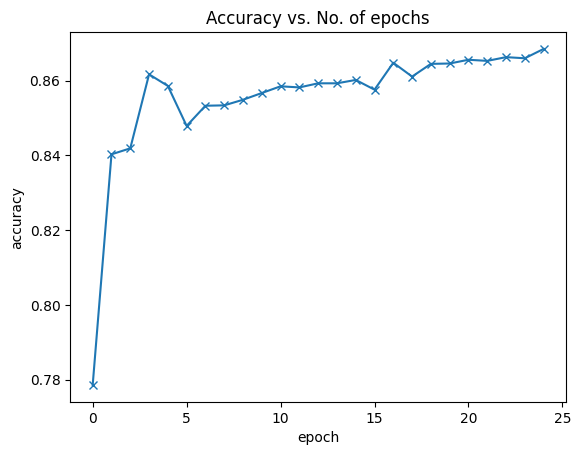

In [74]:

history = [history0, history1, history2, history3]
accuracies = [result['val_acc'] for sublist in history for result in sublist]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()


In [77]:
result = evaluate(model, validation_data)
result

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-1158f8ce7e6b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels) / len(preds))


{'val_loss': 0.3894260823726654, 'val_acc': 0.8685000538825989}

In [62]:
testing_data = FashionMNIST(root='root/', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 13938267.78it/s]


Extracting root/FashionMNIST/raw/train-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 261544.19it/s]


Extracting root/FashionMNIST/raw/train-labels-idx1-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4960413.30it/s]


Extracting root/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13126004.25it/s]

Extracting root/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to root/FashionMNIST/raw



In [63]:
len(testing_data)

10000

In [65]:
testing_dataloader = DataLoader(testing_data, batch_size=100, shuffle=True)

In [66]:
def predict_image(image, label):
  x = image.unsqueeze(0)
  y = model(x)
  _, preds = torch.max(y, dim=1)
  return preds[0].item()

Image label:  9 Predicted Image:  9


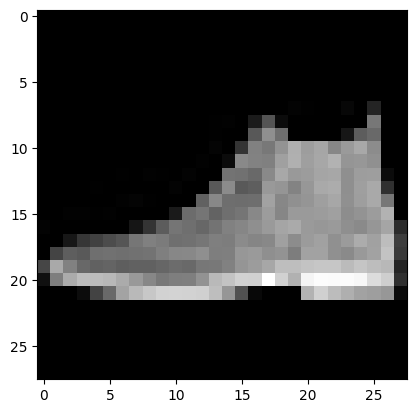

In [67]:
images, labels = testing_data[0]
plt.imshow(images[0], cmap='gray')
print('Image label: ', labels, 'Predicted Image: ', predict_image(images, labels))

Image label:  8 Predicted Image:  8


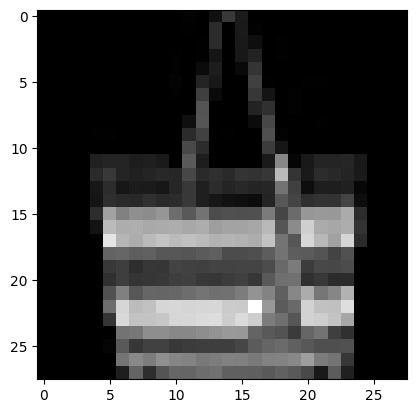

In [68]:
images, labels = testing_data[3445]
plt.imshow(images[0], cmap='gray')
print('Image label: ', labels, 'Predicted Image: ', predict_image(images, labels))

Image label:  8 Predicted Image:  8


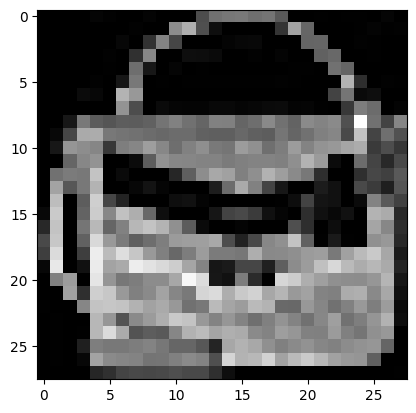

In [70]:
images, labels = testing_data[443]
plt.imshow(images[0], cmap='gray')
print('Image label: ', labels, 'Predicted Image: ', predict_image(images, labels))

In [78]:
torch.save(model.state_dict(), 'fashionMNIST_project.pth')